# Project 1: Plotting Passes - Declan Rice in UEFA Euro 2024

This notebook focuses on the average progressive passes per 90 minutes for Declan Rice and compares to other players in UEFA Euro 2024 who play in the same positions as Declan Rice.

In [4]:
# Install necessary packages if not already installed
# !pip install statsbombpy mplsoccer pandas matplotlib numpy 
#!pip install adjustText




In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsbombpy import sb
from mplsoccer import Pitch, Sbopen

# Ignore any potential warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [6]:
# Initialize parser
parser = Sbopen()

# Fetch competition data for UEFA Euro 2024
comps = sb.competitions()
comps[comps['competition_name'] == 'UEFA Euro']

# Fetch all matches from UEFA Euro 2024
matches = sb.matches(competition_id=55, season_id=282)
matches.head()


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,...,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


In [7]:
# Extract event data for each match and collect all pass data
all_pass_data = []
player_minutes = {}

# Iterate over each match to collect event data for all matches in the tournament
for match in matches['match_id']:
    df, df_related, df_freeze, df_tactics = parser.event(match)
    
    # Check if Declan Rice is in this match
    if 'Declan Rice' in df['player_name'].values:
        # Get all positions Declan Rice has played in this match
        declan_rice_events = df[df['player_name'] == 'Declan Rice']
        declan_rice_positions = declan_rice_events['position_name'].unique()
        break


/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '3421' '4231' '3421']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)


In [8]:
# Now, filter events for only players in the same positions as Declan Rice across all matches
for match in matches['match_id']:
    df, df_related, df_freeze, df_tactics = parser.event(match)
    
    # Filter players who are in the same positions as Declan Rice
    df_position_players = df[df['position_name'].isin(declan_rice_positions)]
    
    # Extract only pass events
    df_passes = df_position_players[df_position_players['type_name'] == 'Pass']
    
    # Track minutes played by each player
    for player in df_position_players['player_name'].unique():
        if player not in player_minutes:
            player_minutes[player] = 0
        
        total_minutes_in_match = df_position_players[df_position_players['player_name'] == player]['minute'].max()
        if total_minutes_in_match > 0:
            player_minutes[player] += total_minutes_in_match
    
    # Determine if each pass is progressive
    def is_progressive(x, y, end_x, end_y):
        start_dist = np.sqrt((105 - x)**2 + (34 - y)**2)
        end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2)
        
        thres = 30 if x < 52.5 else 10  # Adjust threshold based on field position
        return (start_dist - end_dist) > thres
    
    # Update with .loc to avoid warnings
    df_passes.loc[:, 'is_progressive'] = df_passes.apply(lambda row: is_progressive(row['x'], row['y'], row['end_x'], row['end_y']), axis=1)
    
    # Add match_id to track the player's progress across the tournament
    df_passes.loc[:, 'match_id'] = match
    
    # Append this match's data to the overall data
    all_pass_data.append(df_passes)


/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '3421' '4231' '3421']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)
/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '4231' '4231' '41212' '4231']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)
/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible 

In [9]:
# Combine all collected data into a single DataFrame
all_passes_df = pd.concat(all_pass_data, ignore_index=True)

# Calculate the total and progressive passes per player
player_pass_summary = all_passes_df.groupby('player_name').agg(
    total_passes=('id', 'count'),
    progressive_passes=('is_progressive', 'sum')
).reset_index()

# Add total minutes played per player
player_pass_summary['total_minutes'] = player_pass_summary['player_name'].map(player_minutes)

# Calculate average progressive passes per 90 minutes
player_pass_summary['progressive_passes_per_90'] = (
    player_pass_summary['progressive_passes'] / player_pass_summary['total_minutes'] * 90
)

# Calculate total passes per 90
player_pass_summary['total_passes_per_90'] = (
    player_pass_summary['total_passes'] / player_pass_summary['total_minutes'] * 90
)

# Sorting by progressive passes per 90
player_pass_summary_sorted = player_pass_summary.sort_values(by='progressive_passes_per_90', ascending=False)

# Display top players based on progressive passes per 90
player_pass_summary_sorted.head(10)


,player_name,total_passes,progressive_passes,total_minutes,progressive_passes_per_90,total_passes_per_90
86,Toni Kroos,535,106.0,485,19.670103,99.278351
11,Bruno Miguel Borges Fernandes,163,40.0,215,16.744186,68.232558
87,Trent Alexander-Arnold,89,19.0,121,14.132231,66.198347
45,Luka Modrić,64,12.0,97,11.134021,59.381443
27,Hakan Çalhanoğlu,221,33.0,276,10.76087,72.065217
39,Kevin De Bruyne,63,16.0,134,10.746269,42.313433
66,Pierre-Emile Højbjerg,298,38.0,362,9.447514,74.088398
89,Vitor Machado Ferreira,326,35.0,357,8.823529,82.184874
12,Bryan Cristante,34,7.0,74,8.513514,41.351351
30,Jerdy Schouten,316,46.0,516,8.023256,55.116279


In [10]:
# Select data specifically for Declan Rice
declan_rice_data = player_pass_summary_sorted[player_pass_summary_sorted['player_name'] == 'Declan Rice']

# Extract the top 10 players with the highest progressive passes per 90, including Declan Rice for comparison
top_players = player_pass_summary_sorted.head(10)

# Include Declan Rice if not already in the top 10
if 'Declan Rice' not in top_players['player_name'].values:
    top_players = pd.concat([top_players, declan_rice_data], ignore_index=True)

# Display the comparison data for Declan Rice against other top players
top_players


,player_name,total_passes,progressive_passes,total_minutes,progressive_passes_per_90,total_passes_per_90
0,Toni Kroos,535,106.0,485,19.670103,99.278351
1,Bruno Miguel Borges Fernandes,163,40.0,215,16.744186,68.232558
2,Trent Alexander-Arnold,89,19.0,121,14.132231,66.198347
3,Luka Modrić,64,12.0,97,11.134021,59.381443
4,Hakan Çalhanoğlu,221,33.0,276,10.76087,72.065217
5,Kevin De Bruyne,63,16.0,134,10.746269,42.313433
6,Pierre-Emile Højbjerg,298,38.0,362,9.447514,74.088398
7,Vitor Machado Ferreira,326,35.0,357,8.823529,82.184874
8,Bryan Cristante,34,7.0,74,8.513514,41.351351
9,Jerdy Schouten,316,46.0,516,8.023256,55.116279


In [11]:
# Count the number of matches Declan Rice participated in
matches_with_rice = []
for match_id in matches['match_id']:
    df, _, _, _ = parser.event(match_id)
    if 'Declan Rice' in df['player_name'].values:
        matches_with_rice.append(match_id)

# Total number of matches Declan Rice played
no_games = len(matches_with_rice)
print(f"Declan Rice played in {no_games} matches during the tournament.")


/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '3421' '4231' '3421']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)
/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '4231' '4231' '41212' '4231']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)
/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible 

Declan Rice played in 7 matches during the tournament.


/Users/ishaq/Library/Python/3.9/lib/python/site-packages/mplsoccer/statsbomb.py:509: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['4231' '343' '352' '3511' '4231' '4231']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'tactics_formation'] = df.loc[mask, 'tactics_formation'].astype(int).astype(str)


In [12]:
# Filter data for Declan Rice's progressive passes
declan_rice_passes = all_passes_df[(all_passes_df['player_name'] == 'Declan Rice') & (all_passes_df['is_progressive'])]

# Calculate passes per 90 for Declan Rice
minutes_played = player_minutes['Declan Rice']
declan_rice_passes_per_90 = len(declan_rice_passes) / minutes_played * 90 if minutes_played > 0 else 0


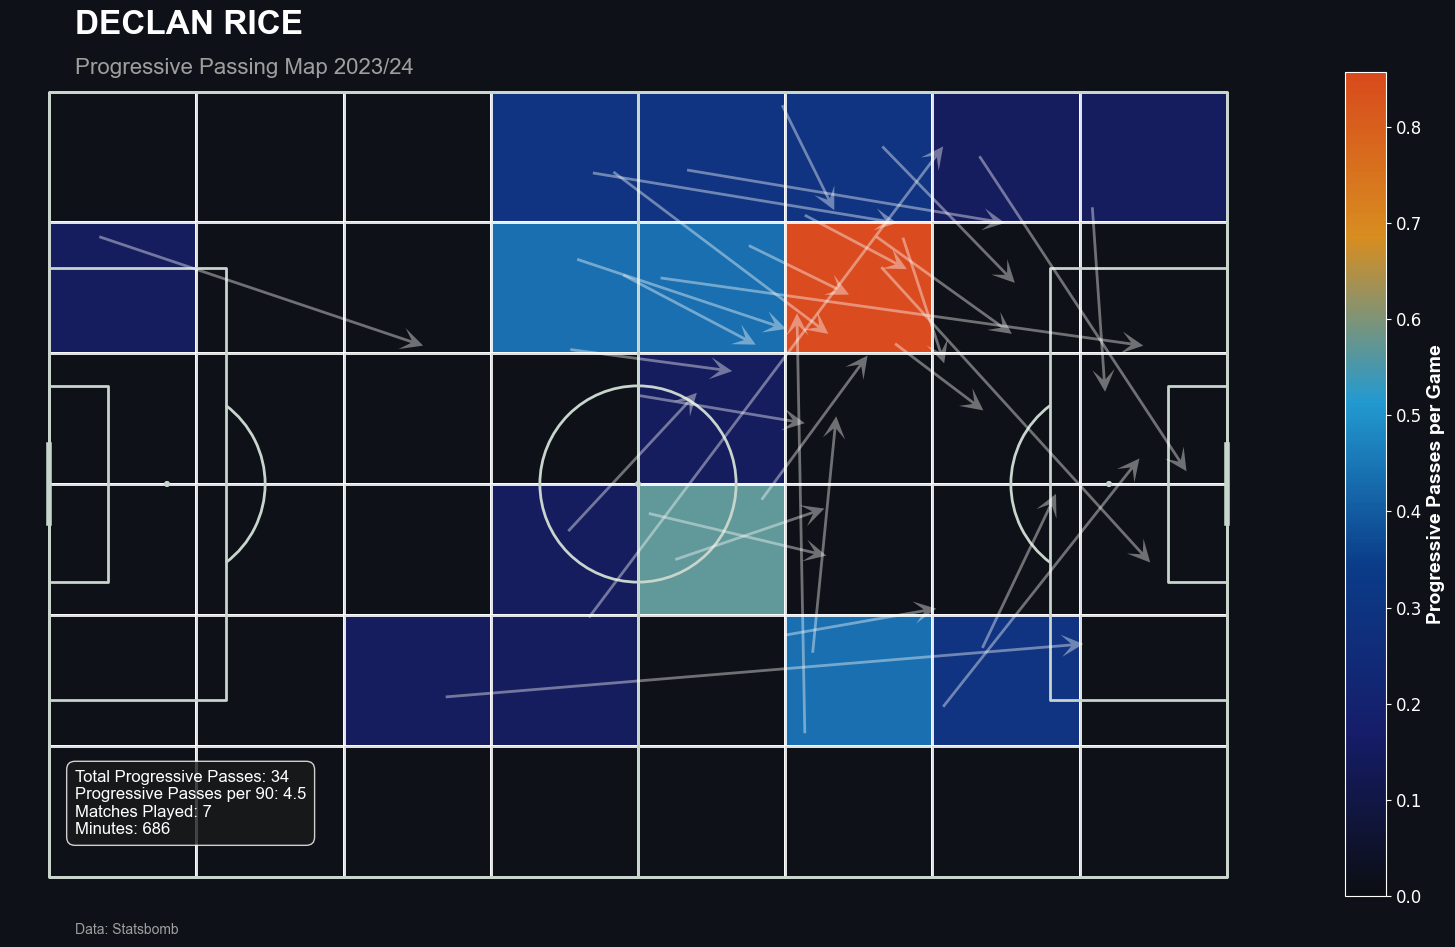

In [22]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Set the style
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#0E1117'

# Create pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0E1117', line_color='#c7d5cc', 
              stripe=False, line_zorder=2)

# Create figure
fig, ax = pitch.draw(figsize=(16, 10))
fig.set_facecolor('#0E1117')
ax.patch.set_facecolor('#0E1117')

# Calculate and normalize heatmap with fewer, more distinct bins
bin_statistic = pitch.bin_statistic(declan_rice_passes['x'], 
                                   declan_rice_passes['y'],
                                   statistic='count',
                                   bins=(8, 6),  # Fewer bins for clearer areas
                                   normalize=False)

bin_statistic["statistic"] = bin_statistic["statistic"] / no_games

# Create more distinct color gradient
colors = ['#0E1117',      # Dark background
          '#1a237e',      # Dark blue
          '#0d47a1',      # Medium blue
          '#29B6F6',      # Light blue
          '#FFA726',      # Orange
          '#FF5722']      # Bright orange-red

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

# Plot heatmap with stronger colors
pcm = pitch.heatmap(bin_statistic, 
                    ax=ax,
                    cmap=custom_cmap,
                    edgecolors='#ffffff',  # White edges for better distinction
                    linewidths=1,          # Thicker lines
                    alpha=0.85)            # Slightly transparent for better visibility

# Add selective arrows for highest-value progressive passes
n_passes = len(declan_rice_passes)
sample_size = min(30, n_passes)  # Fewer arrows for clarity
random_indices = np.random.choice(n_passes, sample_size, replace=False)

for idx in random_indices:
    x_start = declan_rice_passes.iloc[idx]['x']
    y_start = declan_rice_passes.iloc[idx]['y']
    x_end = declan_rice_passes.iloc[idx]['end_x']
    y_end = declan_rice_passes.iloc[idx]['end_y']
    
    pitch.arrows(x_start, y_start,
                x_end, y_end,
                ax=ax,
                width=2,
                headwidth=8,
                headlength=8,
                color='#ffffff',
                alpha=0.4,
                zorder=3)

# Add colorbar with clearer labels
cbar = fig.colorbar(pcm, ax=ax, shrink=0.85)
cbar.set_label('Progressive Passes per Game', 
               color='#ffffff',
               fontsize=14,
               fontweight='bold',
               family='Arial')
cbar.ax.tick_params(colors='#ffffff', labelsize=12)

# Title and subtitle
fig.text(0.05, 0.95, 'DECLAN RICE', 
         fontsize=24, 
         fontweight='bold', 
         color='#ffffff',
         family='Arial')

fig.text(0.05, 0.91, 'Progressive Passing Map 2023/24', 
         fontsize=16,
         color='#9e9e9e',
         family='Arial')

# Stats box with clearer formatting
stats_box = (
    f"Total Progressive Passes: {len(declan_rice_passes)}\n"
    f"Progressive Passes per 90: {declan_rice_passes_per_90:.1f}\n"
    f"Matches Played: {no_games}\n"
    f"Minutes: {minutes_played}"
)

# Add stats with more visible background
bbox_props = dict(boxstyle='round,pad=0.5', facecolor='#1a1a1a', alpha=0.8, edgecolor='#ffffff')
fig.text(0.05, 0.15, stats_box,
         color='#ffffff',
         fontsize=12,
         family='Arial',
         bbox=bbox_props)

# Add data source
fig.text(0.05, 0.05, 'Data: Statsbomb', 
         color='#9e9e9e',
         fontsize=10,
         family='Arial')

plt.tight_layout()
plt.show()

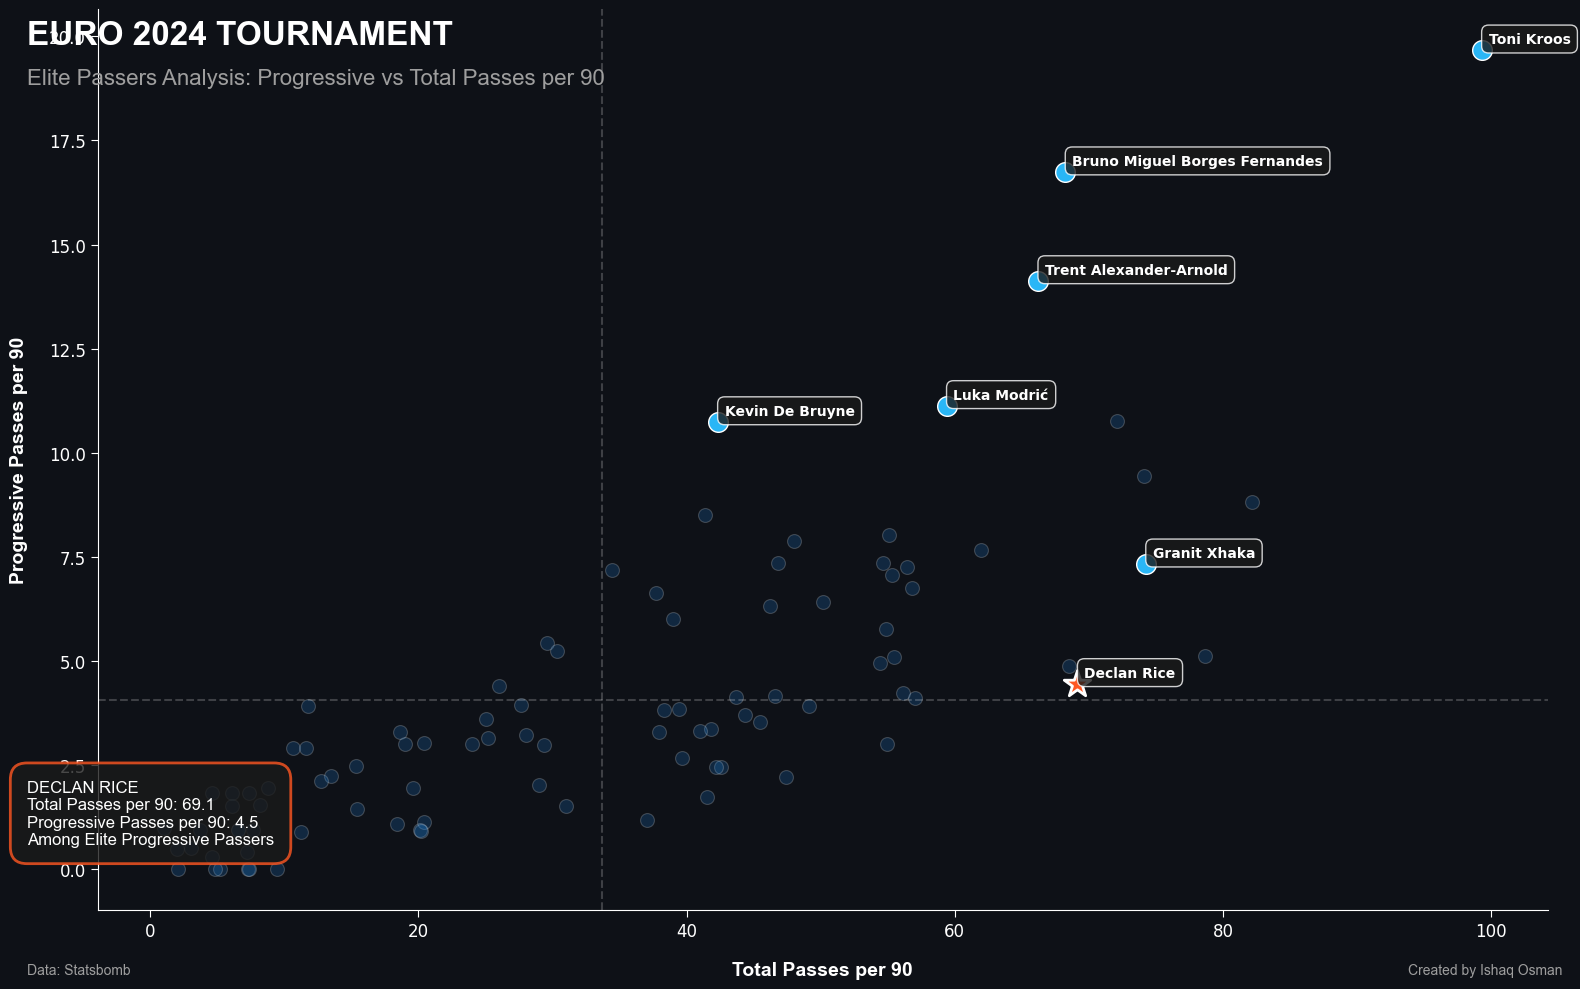

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and figure size
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor('#0E1117')
ax.set_facecolor('#0E1117')

# Filter for key players to show
key_players = [
    'Declan Rice',
    'Toni Kroos',
    'Bruno Miguel Borges Fernandes',
    'Trent Alexander-Arnold',
    'Kevin De Bruyne',
    'Luka Modrić',
    'Granit Xhaka',
    'Rodri'  # If available in your dataset
]

# Create main scatter plot for all players (small and faded)
sns.scatterplot(
    data=player_pass_summary_sorted,
    x='total_passes_per_90',
    y='progressive_passes_per_90',
    s=100,
    color='#1E88E5',
    alpha=0.2,
    ax=ax
)

# Highlight selected players
for player in key_players:
    player_data = player_pass_summary_sorted[player_pass_summary_sorted['player_name'] == player]
    if not player_data.empty:
        if player == 'Declan Rice':
            # Special highlight for Rice
            ax.scatter(
                player_data['total_passes_per_90'],
                player_data['progressive_passes_per_90'],
                s=400,
                color='#FF5722',
                edgecolor='#ffffff',
                linewidth=2,
                marker='*',
                zorder=5
            )
        else:
            # Other key players
            ax.scatter(
                player_data['total_passes_per_90'],
                player_data['progressive_passes_per_90'],
                s=200,
                color='#29B6F6',
                edgecolor='#ffffff',
                linewidth=1,
                zorder=4
            )
        
        # Add labels for key players
        bbox_props = dict(
            boxstyle='round,pad=0.5',
            fc='#1a1a1a',
            ec='#ffffff',
            alpha=0.8,
            linewidth=1
        )
        
        ax.annotate(
            player_data['player_name'].iloc[0],
            (player_data['total_passes_per_90'].iloc[0], 
             player_data['progressive_passes_per_90'].iloc[0]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            color='white',
            bbox=bbox_props,
            zorder=6
        )

# Add quadrant lines with labels
mean_x = player_pass_summary_sorted['total_passes_per_90'].mean()
mean_y = player_pass_summary_sorted['progressive_passes_per_90'].mean()

ax.axvline(x=mean_x, color='#ffffff', linestyle='--', alpha=0.2)
ax.axhline(y=mean_y, color='#ffffff', linestyle='--', alpha=0.2)

# Quadrant labels
quadrant_props = dict(
    boxstyle='round,pad=0.5',
    fc='#1a1a1a',
    ec='none',
    alpha=0.8
)

# Title and subtitle
fig.text(0.02, 0.95, 'EURO 2024 TOURNAMENT', 
         fontsize=24, 
         fontweight='bold', 
         color='#ffffff',
         family='Arial')

fig.text(0.02, 0.91, 'Elite Passers Analysis: Progressive vs Total Passes per 90', 
         fontsize=16,
         color='#9e9e9e',
         family='Arial')

# Stats box for Rice
stats_text = (
    f"DECLAN RICE\n"
    f"Total Passes per 90: {declan_rice_data['total_passes_per_90'].values[0]:.1f}\n"
    f"Progressive Passes per 90: {declan_rice_data['progressive_passes_per_90'].values[0]:.1f}\n"
    f"Among Elite Progressive Passers"
)

bbox_props = dict(
    boxstyle='round,pad=1',
    facecolor='#1a1a1a',
    edgecolor='#FF5722',
    alpha=0.8,
    linewidth=2
)
fig.text(0.02, 0.15, stats_text,
         color='#ffffff',
         fontsize=12,
         family='Arial',
         bbox=bbox_props)

# Axis labels
ax.set_xlabel('Total Passes per 90', 
             fontsize=14, 
             color='#ffffff', 
             fontweight='bold', 
             family='Arial',
             labelpad=15)
ax.set_ylabel('Progressive Passes per 90', 
             fontsize=14, 
             color='#ffffff', 
             fontweight='bold', 
             family='Arial',
             labelpad=15)

# Clean up axes
ax.tick_params(colors='#ffffff', labelsize=12, length=5)
ax.spines['bottom'].set_color('#ffffff')
ax.spines['left'].set_color('#ffffff')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Source and creator info
fig.text(0.02, 0.02, 'Data: Statsbomb', 
         color='#9e9e9e',
         fontsize=10,
         family='Arial')

fig.text(0.98, 0.02, 'Created by Ishaq Osman', 
         horizontalalignment='right',
         color='#9e9e9e',
         fontsize=10,
         family='Arial')

plt.tight_layout()
plt.show()